In [ ]:
!pip install -q torchmetrics
!pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize

import os, csv, random, re

In [ ]:
!gdown 1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD
!unzip -qq ml1m.zip -d ml1m

Downloading...
From: https://drive.google.com/uc?id=1hUqu1mbFeTEfBvl-7fc56fHFfCSzIktD
To: /content/ml1m.zip
100% 105M/105M [00:00<00:00, 274MB/s] 
replace ml1m/content/dataset/movies_test.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# You need extract file ml1m.zip to folder ml1m before run code

users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')


In [ ]:
movies_train

,title,genre
movieid,,
1650,Washington Square (1997),[Drama]
185,"Net, The (1995)","[Sci-Fi, Thriller]"
1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3204,"Boys from Brazil, The (1978)",[Thriller]
1901,Dear Jesse (1997),[Documentary]
...,...,...
2539,Analyze This (1999),[Comedy]
3038,"Face in the Crowd, A (1957)",[Drama]
1832,Heaven's Burning (1997),"[Action, Drama]"


### Data processing
Add `img_path` column to the `movies_train` dataframe
and drop the rows that don't have poster

In [ ]:
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_train.reset_index(inplace=True)
img_paths = []
for index, movie_id in enumerate(movies_train['movieid']):
  img_path = os.path.join(folder_img_path, f"{movie_id}.jpg")
  if not os.path.exists(img_path):
    movies_train.drop(index, axis=0, inplace=True)
  else:
    img_paths.append(img_path)

movies_train['img_path'] = img_paths
movies_train.reset_index(drop=True, inplace=True)
movies_train

,movieid,title,genre,img_path
0,1650,Washington Square (1997),[Drama],ml1m/content/dataset/ml1m-images/1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",ml1m/content/dataset/ml1m-images/185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",ml1m/content/dataset/ml1m-images/1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],ml1m/content/dataset/ml1m-images/3204.jpg
4,2382,Police Academy 5: Assignment: Miami Beach (1988),[Comedy],ml1m/content/dataset/ml1m-images/2382.jpg
...,...,...,...,...
2597,2921,High Plains Drifter (1972),[Western],ml1m/content/dataset/ml1m-images/2921.jpg
2598,502,"Next Karate Kid, The (1994)","[Action, Children's]",ml1m/content/dataset/ml1m-images/502.jpg
2599,2539,Analyze This (1999),[Comedy],ml1m/content/dataset/ml1m-images/2539.jpg
2600,3038,"Face in the Crowd, A (1957)",[Drama],ml1m/content/dataset/ml1m-images/3038.jpg


In [ ]:
# do the same with `movies_test` dataframe
folder_img_path = 'ml1m/content/dataset/ml1m-images'
movies_test.reset_index(inplace=True)
test_img_paths = []
for index, movie_id in enumerate(movies_test['movieid']):
  img_path = os.path.join(folder_img_path, f"{movie_id}.jpg")
  if not os.path.exists(img_path):
    movies_test.drop(index, axis=0, inplace=True)
  else:
    test_img_paths.append(img_path)

movies_test['img_path'] = test_img_paths
movies_test.reset_index(drop=True, inplace=True)
movies_test

,movieid,title,genre,img_path
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",ml1m/content/dataset/ml1m-images/3397.jpg
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",ml1m/content/dataset/ml1m-images/2067.jpg
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],ml1m/content/dataset/ml1m-images/2651.jpg
3,2989,For Your Eyes Only (1981),[Action],ml1m/content/dataset/ml1m-images/2989.jpg
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],ml1m/content/dataset/ml1m-images/3415.jpg
...,...,...,...,...
649,1286,Somewhere in Time (1980),"[Drama, Romance]",ml1m/content/dataset/ml1m-images/1286.jpg
650,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",ml1m/content/dataset/ml1m-images/2421.jpg
651,3255,"League of Their Own, A (1992)","[Comedy, Drama]",ml1m/content/dataset/ml1m-images/3255.jpg
652,974,Algiers (1938),"[Drama, Romance]",ml1m/content/dataset/ml1m-images/974.jpg


In [ ]:
# load labels and turn it into a dictionary
with open("ml1m/content/dataset/genres.txt", "r") as file:
  labels = file.read().split('\n')

labels_map = {}
for index, genre in enumerate(labels):
  labels_map[genre] = index

labels_map

{'Crime': 0,
 'Thriller': 1,
 'Fantasy': 2,
 'Horror': 3,
 'Sci-Fi': 4,
 'Comedy': 5,
 'Documentary': 6,
 'Adventure': 7,
 'Film-Noir': 8,
 'Animation': 9,
 'Romance': 10,
 'Drama': 11,
 'Western': 12,
 'Musical': 13,
 'Action': 14,
 'Mystery': 15,
 'War': 16,
 "Children's": 17}

In [ ]:
# load training target labels
labels_train = np.empty(shape=(len(movies_train['movieid']), 18))
for index, genres_of_movie in enumerate(movies_train['genre']):
  movie_genres = np.zeros(18)
  for genre in genres_of_movie:
    movie_genres[labels_map[genre]] = 1
  labels_train[index] = movie_genres

labels_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [ ]:
sum_labels = np.sum(labels_train, axis=0, dtype='int32')
sum_labels

array([ 161,  349,   58,  244,  219,  832,   53,  223,   34,   83,  345,
       1007,   51,   96,  384,   79,  110,  196], dtype=int32)

In [ ]:
# load testing target labels
labels_test = np.empty(shape=(len(movies_test['movieid']), 18))
for index, genres_of_movie in enumerate(movies_test['genre']):
  movie_genres = np.zeros(18)
  for genre in genres_of_movie:
    movie_genres[labels_map[genre]] = 1
  labels_test[index] = movie_genres

labels_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Datasets

In [ ]:
class MyDataset(Dataset):
    def __init__(self, img_paths, target_genres_, transform_, genres_map_, genres_):
        self.paths = img_paths
        self.target_genres = torch.from_numpy(target_genres_)
        self.genres = genres_
        self.genres_map = genres_map_
        self.transform = transform_ # to edit (resize, ...) and then transform images into Tensor

    def __getitem__(self, index: int):
      img = self.load_image(index)
      genre = self.target_genres[index]
      if len(img.getbands()) == 1: # check if the image have only one channel
        trans = transforms.Grayscale(num_output_channels=3)
        img = trans(img) # convert image to a three-channel image
      return self.transform(img), genre

    def __len__(self) -> int:
      return len(self.paths)

    def load_image(self, index: int) -> Image.Image:
      return Image.open(self.paths[index])

In [ ]:
# Train the model with different image sizes
IMAGE_SIZE_TEST_MAP = {"16": (16, 16),
                       "24": (24, 24),
                       "32": (32, 32),
                       "40": (40, 40),
                       "64": (64, 64),
                       "72": (72, 72),
                       "128": (128, 128),
                       "224": (224, 224),
                       "256": (256, 256)}
IMAGE_SIZE = IMAGE_SIZE_TEST_MAP['224']
transformer = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

In [ ]:
train_dataset = MyDataset(img_paths=movies_train['img_path'], target_genres_=labels_train, transform_=transformer, genres_map_=labels_map, genres_=labels)
test_dataset = MyDataset(img_paths=movies_test['img_path'], target_genres_=labels_test, transform_=transformer, genres_map_=labels_map, genres_=labels)

In [ ]:
len(train_dataset), len(test_dataset)

(2602, 654)

# Visualize datasets

In [ ]:
def display_random(dataset: torch.utils.data.Dataset, genres: list[str], num: int = 8):
  num = 8
  random_index = random.sample(range(len(dataset)), k=num)
  plt.figure(figsize=(16, 6))
  for index, sample_index in enumerate(random_index):
    image, genres = dataset[sample_index][0], dataset[sample_index][1]
    image_adjust = image.permute(1, 2, 0)

    plt.subplot(2, 4, index+1)
    plt.imshow(image_adjust)
    plt.axis("off")

    title = f"Genres: {[labels[index] for index, val in enumerate(genres) if val == 1]}"
    plt.title(title)


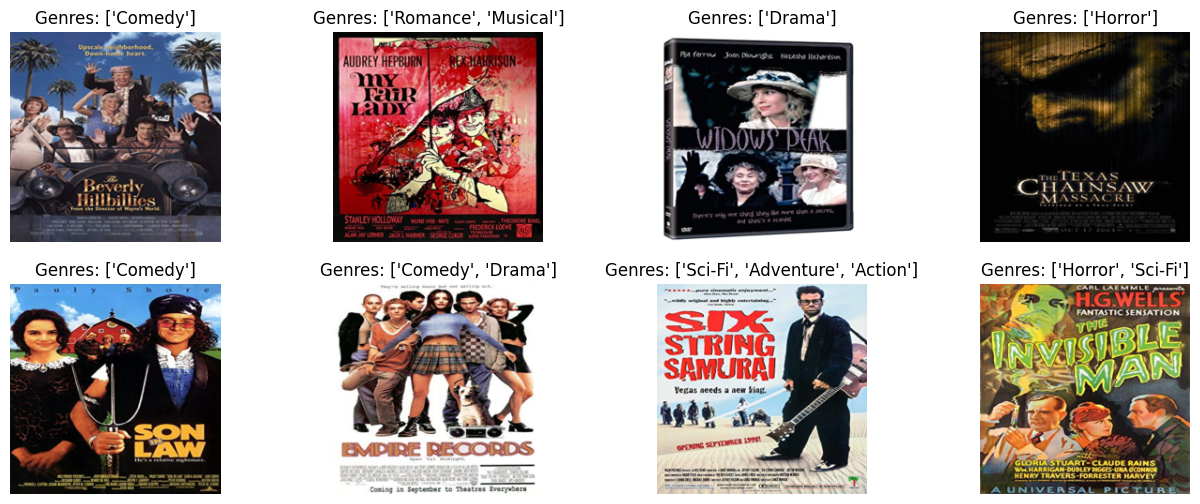

In [ ]:
display_random(train_dataset, labels)

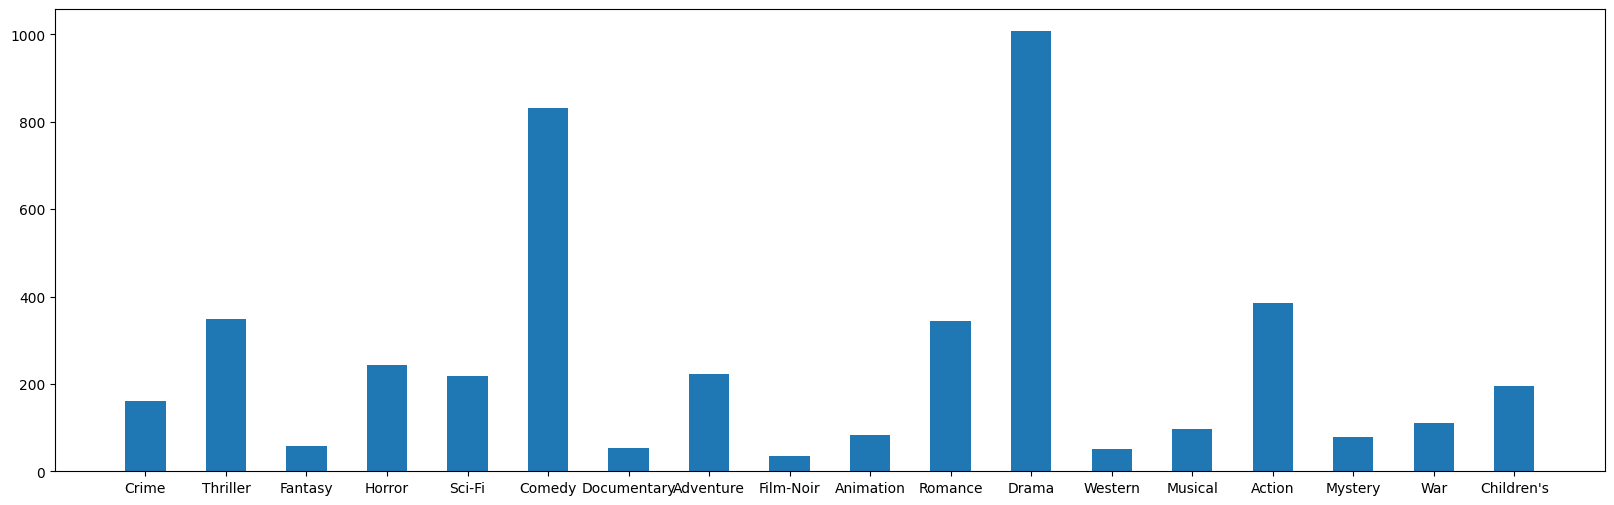

In [ ]:
# plot the genres distribution of movies
def plot_bar_chart(labels_, sum_labels_):
  plt.figure(figsize=(20, 6))

  plt.bar(labels_, sum_labels_, align='center', width=0.5)
  plt.show()

plot_bar_chart(labels, sum_labels)

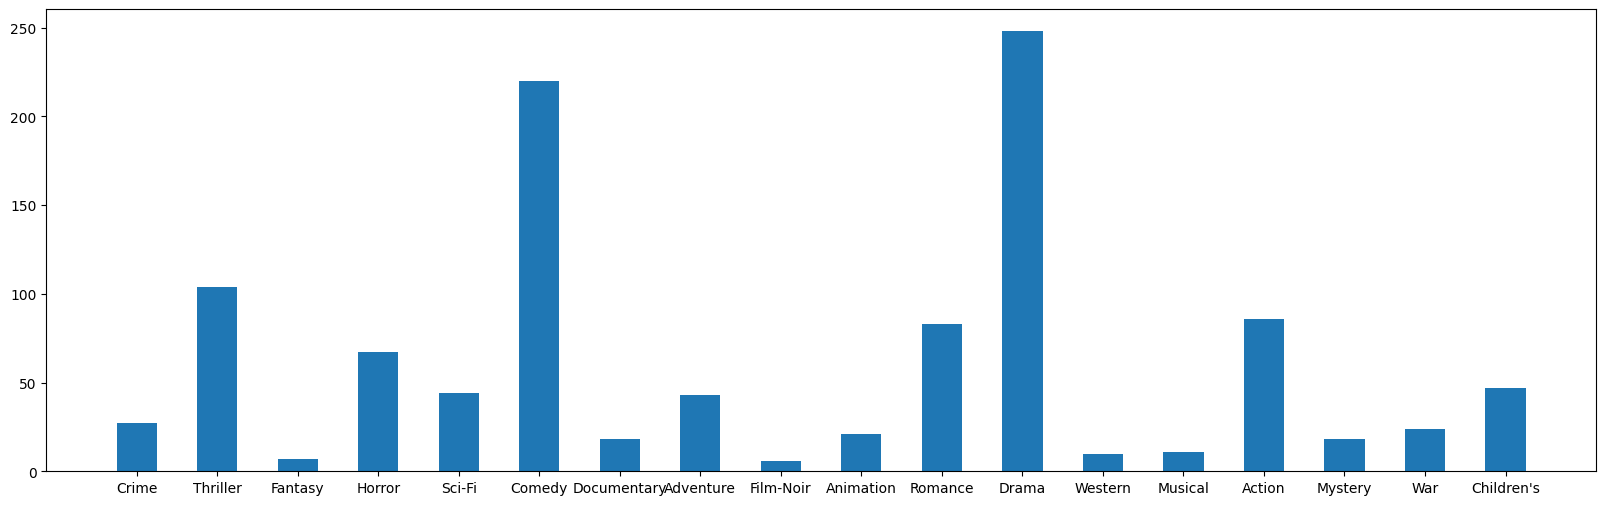

In [ ]:
plot_bar_chart(labels, np.sum(labels_test, axis=0))

# DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

## Model

In [ ]:
class BaseModel(nn.Module):
  """ A model that replicates the architecture of TinyVGG model """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*int(IMAGE_SIZE[0]/4)*int(IMAGE_SIZE[0]/4), out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=output_shape)
    )

  def forward(self, x):
    out_1 = self.conv_block_1(x)
    # print(out_1.shape)
    out_2 = self.conv_block_2(out_1)
    # print(out_2.shape)
    res = self.classifier(out_2)
    return res

In [ ]:
model = BaseModel(input_shape=3, hidden_units=32, output_shape=len(labels)).to(device)

In [ ]:
# take a test sample in the training data
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 18]))

In [ ]:
# making sure the model working, you can ignore the output
model(img.to(device))[0]

tensor([ 0.0097,  0.0678, -0.0545, -0.0454, -0.0183, -0.0364,  0.0699, -0.0001,
         0.0140,  0.0427, -0.0617, -0.0161, -0.0690,  0.0012, -0.0413,  0.0841,
        -0.0724, -0.1032], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
from torchinfo import summary

# summarize the base model which replicates the architecture of TinyVGG
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [32, 18]                  --
├─Sequential: 1-1                        [32, 32, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─ReLU: 2-2                         [32, 32, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 32, 224, 224]        9,248
│    └─ReLU: 2-4                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 32, 112, 112]        --
├─Sequential: 1-2                        [32, 32, 56, 56]          --
│    └─Conv2d: 2-6                       [32, 32, 112, 112]        9,248
│    └─ReLU: 2-7                         [32, 32, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 32, 112, 112]        9,248
│    └─ReLU: 2-9                         [32, 32, 112, 112]        --
│    └─MaxPool2d: 2-10                   [32, 32, 56, 56]          --
├─Seq

## Loss

In [ ]:
from torch import optim

learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()

basemodel_optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

## Train function

In [ ]:
def train_steps(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer, device):
  # put model in training mode
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    N, C = y_pred.shape
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.sigmoid(y_pred)
    y_pred_class[y_pred_class >= 0.5] = 1
    y_pred_class[y_pred_class < 0.5] = 0
    train_acc += (y_pred_class == y).sum().item()/(N*C)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


# Test function

In [ ]:
def test_steps(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, eval_metrics, device):
  model.eval()
  score_all = 0
  mapk_score = 0
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      score_all += eval_metrics(y_pred, y)

  return score_all/len(dataloader)

# Training and Testing BaseModel

In [ ]:
from tqdm.auto import tqdm

# for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

for ep in tqdm(range(epochs)):
  # train_loss, train_acc = train_steps(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=basemodel_optimizer, device=device)
  # print(f"Epoch: {ep} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
  pass

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from torchmetrics.classification import MultilabelF1Score

f1 = MultilabelF1Score(num_labels=len(labels), threshold=0.5, average='macro')
f1 = f1.to(device)

f1_score = test_steps(model, test_dataloader, f1, device)

print('F1 score: ', f1_score)
# print('Mapk score', mapk_score)


F1 score:  tensor(0.0324, device='cuda:0')


# Using pre-trained DenseNet model

In [ ]:
class DenseNet169Model(nn.Module):
  def __init__(self, model, input_shape: int, output_shape: int):
    super().__init__()
    self.model = model
    self.model.classifier = nn.Sequential(
        # densenet 169
        nn.Linear(in_features=1664, out_features=1024),
        nn.ReLU(),
    )
    self.classifier = nn.Sequential(
        nn.Linear(in_features=1024, out_features=512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.model(x))

class DenseNet121Model(nn.Module):
  def __init__(self, model, input_shape: int, output_shape: int):
    super().__init__()
    self.model = model
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features=1024, out_features=512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=output_shape)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
from torchvision.models import DenseNet121_Weights, densenet121, DenseNet169_Weights, densenet169

# DenseNet121
densenet_pretrained = densenet121(weights=DenseNet121_Weights.DEFAULT)
# densenet_pretrained = densenet121(weights=None)
densenet_model = DenseNet121Model(model=densenet_pretrained, input_shape=3, output_shape=18)

# DenseNet169
# densenet_pretrained = densenet169(weights=DenseNet169_Weights.DEFAULT)
# densenet_pretrained = densenet169(weights=None)
# densenet_model = DenseNet169Model(model=densenet_pretrained, input_shape=3, output_shape=18)

densenet_model.to(device)

densenet_optimizer = optim.Adam(params=densenet_model.parameters(), lr=learning_rate)

In [ ]:
DENSENET_IMG_SIZE = IMAGE_SIZE_TEST_MAP['256']
densenet_transformer = transforms.Compose([
    transforms.Resize(size=DENSENET_IMG_SIZE),
    # transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# densenet dataset
densenet_dataset_train = MyDataset(img_paths=movies_train['img_path'], target_genres_=labels_train, transform_=densenet_transformer, genres_map_=labels_map, genres_=labels)
densenet_dataset_test = test_dataset = MyDataset(img_paths=movies_test['img_path'], target_genres_=labels_test, transform_=densenet_transformer, genres_map_=labels_map, genres_=labels)
# densenet dataloader
densenet_dataloader_train = DataLoader(dataset=densenet_dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
densenet_dataloader_test = DataLoader(dataset=densenet_dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [ ]:
img_dense, label_dense = next(iter(densenet_dataloader_train))
img_dense.shape, label_dense.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 18]))

In [ ]:
densenet_model(img_dense.to(device))[0]

tensor([ 0.5697, -0.6437, -0.2551,  1.2610, -0.0974, -0.3780,  0.0710, -0.7754,
        -1.2567,  0.2688,  0.2627, -0.6887, -1.0428, -0.1803, -0.2193,  0.2336,
         0.1879,  0.0580], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
# for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for ep in tqdm(range(epochs)):
  # train_loss, train_acc = train_steps(model=densenet_model, dataloader=densenet_dataloader_train, loss_fn=loss_fn, optimizer=densenet_optimizer, device=device)
  # print(f"Epoch: {ep} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
  pass

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 4.2628 | Train accuracy: 0.7087
Epoch: 1 | Train loss: 3.9724 | Train accuracy: 0.7319
Epoch: 2 | Train loss: 3.8790 | Train accuracy: 0.7308


In [ ]:
f1_score = test_steps(densenet_model, densenet_dataloader_test, f1, device)
f1_score

# Using pre-trained VGG16

In [ ]:
class VGG16Model(nn.Module):
  def __init__(self, model, input_shape: int, output_shape: int):
    super().__init__()
    self.model = model
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features=25088, out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=output_shape)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
from torchvision.models import vgg16, VGG16_Weights

# vgg16_pretrained = vgg16(weights=VGG16_Weights.DEFAULT)
# vgg_model = VGG16Model(model=vgg16_pretrained, input_shape=3, output_shape=18)
# vgg_model.to(device)

# vgg16_optimizer = optim.Adam(params=vgg_model.parameters(), lr=learning_rate)

In [ ]:
# densenet dataset
vgg_dataset_train = MyDataset(img_paths=movies_train['img_path'], target_genres_=labels_train, transform_=densenet_transformer, genres_map_=labels_map, genres_=labels)
vgg_dataset_test = test_dataset = MyDataset(img_paths=movies_test['img_path'], target_genres_=labels_test, transform_=densenet_transformer, genres_map_=labels_map, genres_=labels)
# densenet dataloader
vgg_dataloader_train = DataLoader(dataset=vgg_dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
vgg_dataloader_test = DataLoader(dataset=vgg_dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [ ]:
# for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for ep in tqdm(range(epochs)):
    # train_loss, train_acc = train_steps(model=vgg_model, dataloader=vgg_dataloader_train, loss_fn=loss_fn, optimizer=vgg16_optimizer, device=device)
    # print(f"Epoch: {ep} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
    pass

In [ ]:
# f1_score = test_steps(vgg_model, vgg_dataloader_test, f1, device)
# f1_score